### Projeto 5 - Recurrent Neural Network (RNN)

## Introdução

### Exemplo 01 - Aplicação de RNN para predição de série temporal

Neste exemplo, será utilizado das redes neurais recorrentes para predição de váriaveis climáticas de uma cidade da Dinamarca baseado nos valores de estações meteorológicas de cidades vizinhas.

#### Dataset
Os dados das estações meteorológicas das cidades de Aalborg, Aarhus, Esbjerg, Odense, Roskilde na Dinamarca para o periodo de 1980-2018.

#### TensorFlow e Keras 
- TensorFlow: É uma biblioteca de código aberto para aprendizado de MachineLearning (Aprendizado de máquina), para este exemplo iremos utilizar a biblioteca tensorflow para linguagem Python
- Keras: O Keras é uma biblioteca especifica para redes neurais feita em Python, tal biblioteca é rodada sobre o TensorFlow e projetada para experimentação rápida de redes neurais profundas.

### Fluxograma

Para esta aplicação, os valores de Temperatura, Pressão Atmosférica e Velocidade do Vento (Temp, Pressure, WindSpeed) da cidade de 'Odense' tentaram ser previstos para as próximas 24 horas a partir dos dados anteriores de 5 outras cidades.

As Redes Neurais Recorrentes (RNN) foram utilizadas devido sua capacidade de trabalhar com sequências de dados com comprimento arbitrário.
Durante o periodo de treinamento da rede, serão utilizados uma sub-sequência de 1344 pontos de dados (8 semanas) do conjunto de treinamento, onde cada ponto de observações possui 20 sinais de entrada para as variáveis climáticas citadas anteriormente.
Após o treinamento da rede neural, o objetivo será produzir sinal das três variáveis (Temp, Pressure, WindSpeed) para o próximo dia, no fluxograma a baixo podemos ver como a rede está descrita a partir da entrada de sinais até a saída passando pela RNN.

<img src="imgs/rnn_01.png" align="center" alt="Drawing" style="width: 600px;">
Fonte: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

### Bibliotecas

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

Bibliotecas do Keras

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Versões utilizadas

In [3]:
print('Versão do TensorFlow: ',tf.__version__)
print('Versão do Keras: ',tf.keras.__version__)
print('Versão do Pandas: ',pd.__version__)

Versão do TensorFlow:  1.15.0
Versão do Keras:  2.2.4-tf
Versão do Pandas:  0.25.2


## Carregando dados

Para baixar os dados das 5 cidades será necessário que os arquivos 'weather.py' e 'download.py' estejam no mesmo diretório deste documento. Os dados meteorológicos das estações foram obtidos a partir do National Climatic Data Center (NCDC), USA. Os arquivos brutos foram extraidos e armazenados no diretório '/dataset'.

In [26]:
import weather
# Função para download e extração automática dos dados
weather.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [27]:
# Lista das cidades
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

Após baixar e setar a lista de cidades será necessário carregar os valores para um DataFrame. Os dados serão carregados e organizados para intervalos de 60 minutos.

In [28]:
df = weather.load_resampled_data()
df.head()

Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333      NaN   
1980-03-01 12:00:00  1008.600000      13.4   280.0  6.583333      NaN   
1980-03-01 13:00:00  1008.433333      15.4   280.0  6.888889      NaN   
1980-03-01 14:00:00  1008.266667      14.9   300.0  6.222222      NaN   
1980-03-01 15:00:00  1008.100000      17.0   290.0  5.555556      NaN   

                                              Odense                          \
                     WindSpeed     WindDir      Temp     Pressure  WindSpeed   
DateTime                                                                       
1980-03-01 11:00:00  12.383333  310.000000  6.142857  1011.066667  12.585714   
1980-03-01 12:00:00  12.883333  310.000000  7.000000  1011.200000  11.300000   
1980-03-01 13:00:00  13.244444  309.444444  7.000000  1011.300000  12.118182   
1980-03-01 14:00:00  12.911111  306.111111  6.857143  1011.400000  12.742857   
1980-03-01 15:00:00  12.577778  302.777778  6.000000  1011.500000  12.400000   

                             Roskilde                                  
                    WindDir      Temp Pressure  WindSpeed     WindDir  
DateTime                                                               
1980-03-01 11:00:00   290.0  5.000000      NaN  11.466667  280.000000  
1980-03-01 12:00:00   290.0  5.000000      NaN  12.466667  280.000000  
1980-03-01 13:00:00   290.0  5.166667      NaN  13.133333  278.333333  
1980-03-01 14:00:00   290.0  5.833333      NaN  12.300000  270.000000  
1980-03-01 15:00:00   290.0  4.833333      NaN  12.300000  270.000000

Em alguns casos existem dados que não foram registrados e por isso interpolados linearmente para completar a série
No caso das cidades de Esbjerg e Roskilde existem dados de pressão atmosférica que não foram registrados e podem ser vistos nos gráficos a baixo. 

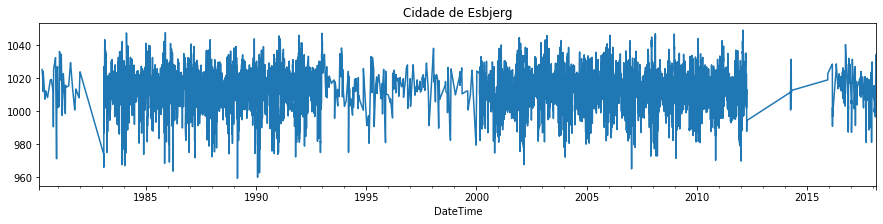

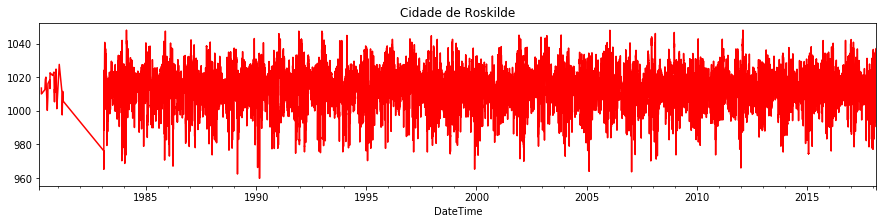

In [29]:
df['Esbjerg']['Pressure'].plot(title='Cidade de Esbjerg', figsize=(15,3))
plt.show()
df['Roskilde']['Pressure'].plot(title='Cidade de Roskilde', figsize=(15,3), color='r')
plt.show()

Devido a utilização de dados de reamostra, foram preenchidos os valores exclusos com valores interpolados linearmente a partir dos vizinhos, porém isso pode confundir a rede neural, por tanto, estas informações devem ser removidas do DataFrame.
Devido a falta de períodos curtos é possivel gerar esses dados a partir de um modelo preditivo que gera os dados ausentes.

In [30]:
print('Quantidade de registros: ', df.values.shape[0], ', Quantidade de entradas: ',df.values.shape[1])
#Função para remoção de valores da coluna 'Pressure' para as cidades Esbjerg e Rosklide
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)
print('Quantidade de registros : ', df.values.shape[0], ', Quantidade de entradas após remoção: ',df.values.shape[1])

Quantidade de registros:  333109 , Quantidade de entradas:  20
Quantidade de registros :  333109 , Quantidade de entradas após remoção:  18


Primeiras linhas do DataFrame sem a coluna 'Pressure'

In [42]:
df[['Esbjerg','Roskilde']].head()

Esbjerg                         Roskilde             \
                         Temp  WindSpeed     WindDir      Temp  WindSpeed   
DateTime                                                                    
1980-03-01 11:00:00  6.083333  12.383333  310.000000  5.000000  11.466667   
1980-03-01 12:00:00  6.583333  12.883333  310.000000  5.000000  12.466667   
1980-03-01 13:00:00  6.888889  13.244444  309.444444  5.166667  13.133333   
1980-03-01 14:00:00  6.222222  12.911111  306.111111  5.833333  12.300000   
1980-03-01 15:00:00  5.555556  12.577778  302.777778  4.833333  12.300000   

                                 
                        WindDir  
DateTime                         
1980-03-01 11:00:00  280.000000  
1980-03-01 12:00:00  280.000000  
1980-03-01 13:00:00  278.333333  
1980-03-01 14:00:00  270.000000  
1980-03-01 15:00:00  270.000000

### Erros nos Dados
Outro problema nos dados é que em alguns períodos a variação de temperatura exibida possui saltos nos valores de temperatura, como em Odense com saltos de temperatura de até 50 ºC, porém a temperatura máxima na Dinamarca chega apenas a 36.4 ºC e a mínima a -32.2ºC, estes dados necessitam de um tratamento para evitar erros na predição.

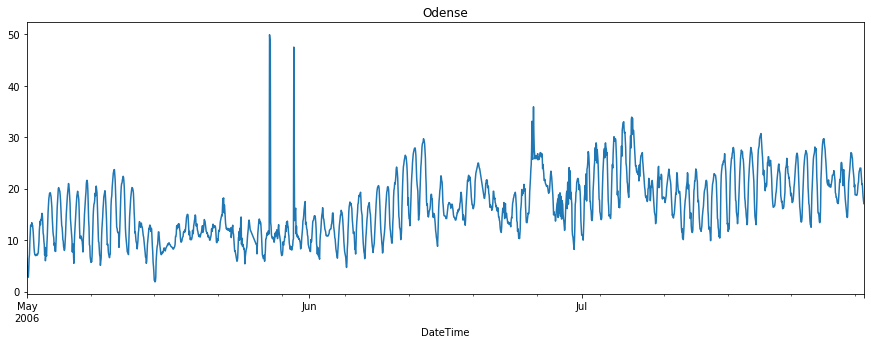

In [51]:
df['Odense']['Temp']['2006-05':'2006-07'].plot(title='Odense',figsize=(15,5))
plt.show()

Essa variação de dados incorreta pode ser confirmada se considerar os dados da cidade de Aarhus, devido a Dinamarca ser um pais com extensões relativamente pequenas é possível considerar os dados de uma estação vizinha.

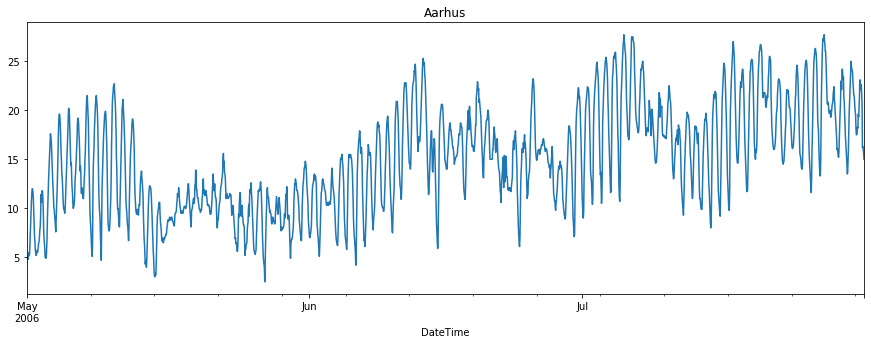

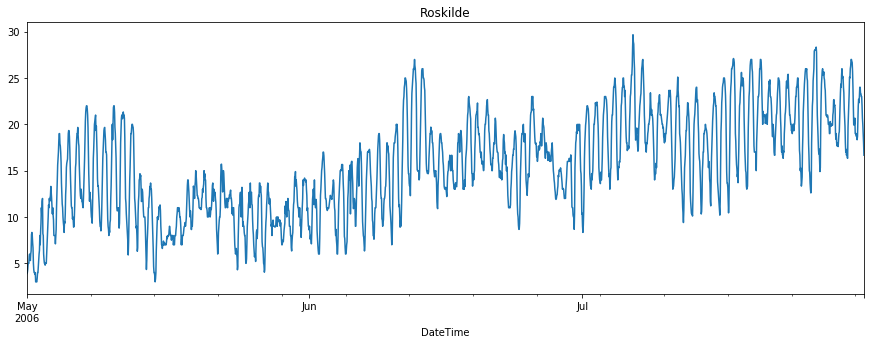

In [56]:
df['Aarhus']['Temp']['2006-05':'2006-07'].plot(title='Aarhus',figsize=(15,5))
plt.show()
df['Roskilde']['Temp']['2006-05':'2006-07'].plot(title='Roskilde',figsize=(15,5))
plt.show()

## Adicionando dados

É possível adicionar alguns sinais de entrada para os dados, e isso ajuda a melhorar o modelo de previsões, por exemplo, dada uma temperatura de 10ºC, o modelo não consegue distinguir se está temperatura seria medida durante o periodo do dia ou da noite, verão ou inverno, o modelo teria que inferir isso a partir dos pontos de dados circundantes, que podem não ter uma precisão alta para determinar se o período é de um inverno anormal quente por exemplo, ou se é no periodo da noite ou do dia, por tanto, essas informações podem influênciar diretamente na precisão do modelo e na sua saída.


Embora o conjunto de dados contenha as informações de data e hora de cada observação, ele é usado apenas no índice para ordenar os dados, portanto, adicionaremos sinais de entrada separados ao conjunto de dados para o dia do ano (entre 1 e 366) e a hora do dia (entre 0 e 23).

In [62]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour
df.Various.head()

,Day,Hour
DateTime,,
1980-03-01 11:00:00,61,11
1980-03-01 12:00:00,61,12
1980-03-01 13:00:00,61,13
1980-03-01 14:00:00,61,14
1980-03-01 15:00:00,61,15


### Selecionando a cidade para previsão

A cidade selecionada será a cidade de Odense e as variáveis serão 'Temp, WindSpeed, Pressure' (Temperatura, Velocidade do Vento e Pressão Atmosférica) e a previsão busca fazer previsões para as próximas 24 horas.

A seguir, é apresentado o número de etapas de tempo em que alteraremos os dados alvos, nosso conjunto de dados é amostrado novamente para ter uma observação para cada hora; portanto, existem 24 observações por 24 horas.

Se queremos prever o tempo 24 horas no futuro, alteramos os dados em 24 etapas. Se quisermos prever o tempo em 7 dias, mudaremos os dados em 7 * 24 intervalos de tempo.

## Target data for prediction

In [77]:
target_city = 'Odense'
target_names = ['Temp', 'WindSpeed', 'Pressure']
shift_days = 1
shift_steps = shift_days * 24

As primeiras linhas do DataFrame correspondem ao inicio da série temporal, já as ultimas 24 linhas ao período que se busca prever

In [78]:
# Novo DataFrame com os valores dos dados para previsão
df_targets = df[target_city][target_names].shift(-shift_steps)
df_targets

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,2.000000,6.828571,1005.833333
1980-03-01 12:00:00,2.000000,8.200000,1005.200000
1980-03-01 13:00:00,0.166667,9.216667,1004.766667
1980-03-01 14:00:00,1.000000,11.885714,1004.333333
1980-03-01 15:00:00,1.000000,12.400000,1003.900000
...,...,...,...
2018-03-01 19:00:00,NaN,NaN,NaN
2018-03-01 20:00:00,NaN,NaN,NaN
2018-03-01 21:00:00,NaN,NaN,NaN


AVISO! Você deve verificar se mudou os dados na direção certa! Queremos prever o futuro, não o passado!
O quadro de dados deslocado é confuso porque o Pandas mantém os carimbos de data / hora originais, mesmo que tenhamos alterado os dados. Você pode verificar se a mudança de horário está correta comparando os quadros de dados originais e com alteração de horário.

Esta é a primeira shift_steps + 5 linhas do quadro de dados original:

In [80]:
df[target_city][target_names].head(shift_steps + 5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,6.142857,12.585714,1011.066667
1980-03-01 12:00:00,7.000000,11.300000,1011.200000
1980-03-01 13:00:00,7.000000,12.118182,1011.300000
1980-03-01 14:00:00,6.857143,12.742857,1011.400000
1980-03-01 15:00:00,6.000000,12.400000,1011.500000
1980-03-01 16:00:00,4.909091,12.618182,1011.688889
1980-03-01 17:00:00,3.953488,12.646512,1011.877778
1980-03-01 18:00:00,3.674419,11.725581,1012.066667
1980-03-01 19:00:00,3.395349,10.804651,1012.255556


A seguir, são apresentadas as 5 primeiras linhas do DataFrame deslocados no tempo. Isso deve ser idêntico às 5 últimas linhas mostradas acima dos dados originais, exceto o carimbo de data / hora.

In [82]:
df_targets.head(5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,2.000000,6.828571,1005.833333
1980-03-01 12:00:00,2.000000,8.200000,1005.200000
1980-03-01 13:00:00,0.166667,9.216667,1004.766667
1980-03-01 14:00:00,1.000000,11.885714,1004.333333
1980-03-01 15:00:00,1.000000,12.400000,1003.900000


O DataFrame com deslocamento no tempo tem o mesmo tamanho que o quadro de dados original, mas as últimas 24 observações são NaN (não número) porque os dados foram deslocados para trás.

In [86]:
df_targets.tail()

,Temp,WindSpeed,Pressure
DateTime,,,
2018-03-01 19:00:00,NaN,NaN,NaN
2018-03-01 20:00:00,NaN,NaN,NaN
2018-03-01 21:00:00,NaN,NaN,NaN
2018-03-01 22:00:00,NaN,NaN,NaN
2018-03-01 23:00:00,NaN,NaN,NaN


In [95]:
df[0:-shift_steps].tail()

Aalborg                            Aarhus           \
                       Temp Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                 
2018-02-28 19:00:00    -6.6   1037.7       8.2    70.0   -5.1   1035.9   
2018-02-28 20:00:00    -7.1   1037.5       6.7    70.0   -5.4   1035.8   
2018-02-28 21:00:00    -6.5   1037.0       8.8    80.0   -5.3   1035.6   
2018-02-28 22:00:00    -6.0   1036.9       9.3    80.0   -5.4   1035.2   
2018-02-28 23:00:00    -6.9   1036.4       7.7    70.0   -5.5   1034.9   

                                        Esbjerg                      Odense  \
                    WindSpeed WindDir      Temp WindSpeed    WindDir   Temp   
DateTime                                                                      
2018-02-28 19:00:00       8.2    80.0 -6.000000  8.400000  80.000000   -6.3   
2018-02-28 20:00:00       9.3    80.0 -6.000000  9.300000  80.000000   -6.6   
2018-02-28 21:00:00       9.3    80.0 -6.333333  8.766667  76.666667   -6.9   
2018-02-28 22:00:00       8.8    70.0 -6.700000  7.700000  60.000000   -7.0   
2018-02-28 23:00:00       8.8    70.0 -6.700000  7.100000  70.000000   -7.0   

                                               Roskilde                    \
                    Pressure WindSpeed WindDir     Temp WindSpeed WindDir   
DateTime                                                                    
2018-02-28 19:00:00   1032.8       9.3    70.0     -7.1       7.7    70.0   
2018-02-28 20:00:00   1032.6      10.8    60.0     -7.3       6.7    60.0   
2018-02-28 21:00:00   1032.4       9.8    60.0     -7.7       5.7    60.0   
2018-02-28 22:00:00   1032.3       9.3    70.0     -7.8       5.7    60.0   
2018-02-28 23:00:00   1031.9      10.3    60.0     -7.7       4.1    60.0   

                    Various       
                        Day Hour  
DateTime                          
2018-02-28 19:00:00      59   19  
2018-02-28 20:00:00      59   20  
2018-02-28 21:00:00      59   21  
2018-02-28 22:00:00      59   22  
2018-02-28 23:00:00      59   23

In [96]:
df.tail()

Aalborg                            Aarhus           \
                       Temp Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                 
2018-03-01 19:00:00    -4.4   1024.2       7.2    70.0   -3.6   1022.7   
2018-03-01 20:00:00    -4.3   1023.7       6.7    70.0   -3.9   1022.2   
2018-03-01 21:00:00    -3.9   1023.1       8.8    80.0   -3.5   1021.7   
2018-03-01 22:00:00    -3.8   1022.9       7.2    70.0   -3.5   1021.2   
2018-03-01 23:00:00    -4.2   1022.5       7.2    70.0   -3.4   1021.0   

                                        Esbjerg                      Odense  \
                    WindSpeed WindDir      Temp WindSpeed    WindDir   Temp   
DateTime                                                                      
2018-03-01 19:00:00       8.8    70.0 -5.000000  6.366667  70.000000   -4.4   
2018-03-01 20:00:00       8.2    60.0 -4.333333  6.866667  80.000000   -5.0   
2018-03-01 21:00:00       8.2    80.0 -5.000000  8.200000  80.000000   -5.2   
2018-03-01 22:00:00       8.2    80.0 -5.000000  6.366667  66.666667   -5.0   
2018-03-01 23:00:00       7.7    80.0 -5.333333  6.533333  60.000000   -4.7   

                                               Roskilde                    \
                    Pressure WindSpeed WindDir     Temp WindSpeed WindDir   
DateTime                                                                    
2018-03-01 19:00:00   1020.4       8.8    60.0     -4.4       6.2    60.0   
2018-03-01 20:00:00   1019.8       8.2    60.0     -4.6       6.2    70.0   
2018-03-01 21:00:00   1019.2       7.7    60.0     -5.1       5.1    60.0   
2018-03-01 22:00:00   1018.7       8.8    60.0     -5.2       5.1    60.0   
2018-03-01 23:00:00   1018.3       9.3    60.0     -5.3       4.1    60.0   

                    Various       
                        Day Hour  
DateTime                          
2018-03-01 19:00:00      60   19  
2018-03-01 20:00:00      60   20  
2018-03-01 21:00:00      60   21  
2018-03-01 22:00:00      60   22  
2018-03-01 23:00:00      60   23

### DataFrame para Vetor

Para entrada da rede é necessário converter o DataFrame (Pandas) para um vetor, isso é feito através da biblioteca NumPy, é necessário remover a ultima parte que contem valores NaN

In [99]:
# Parte final do DataFrame original (01-03-2018)
df.tail()

Aalborg                            Aarhus           \
                       Temp Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                 
2018-03-01 19:00:00    -4.4   1024.2       7.2    70.0   -3.6   1022.7   
2018-03-01 20:00:00    -4.3   1023.7       6.7    70.0   -3.9   1022.2   
2018-03-01 21:00:00    -3.9   1023.1       8.8    80.0   -3.5   1021.7   
2018-03-01 22:00:00    -3.8   1022.9       7.2    70.0   -3.5   1021.2   
2018-03-01 23:00:00    -4.2   1022.5       7.2    70.0   -3.4   1021.0   

                                        Esbjerg                      Odense  \
                    WindSpeed WindDir      Temp WindSpeed    WindDir   Temp   
DateTime                                                                      
2018-03-01 19:00:00       8.8    70.0 -5.000000  6.366667  70.000000   -4.4   
2018-03-01 20:00:00       8.2    60.0 -4.333333  6.866667  80.000000   -5.0   
2018-03-01 21:00:00       8.2    80.0 -5.000000  8.200000  80.000000   -5.2   
2018-03-01 22:00:00       8.2    80.0 -5.000000  6.366667  66.666667   -5.0   
2018-03-01 23:00:00       7.7    80.0 -5.333333  6.533333  60.000000   -4.7   

                                               Roskilde                    \
                    Pressure WindSpeed WindDir     Temp WindSpeed WindDir   
DateTime                                                                    
2018-03-01 19:00:00   1020.4       8.8    60.0     -4.4       6.2    60.0   
2018-03-01 20:00:00   1019.8       8.2    60.0     -4.6       6.2    70.0   
2018-03-01 21:00:00   1019.2       7.7    60.0     -5.1       5.1    60.0   
2018-03-01 22:00:00   1018.7       8.8    60.0     -5.2       5.1    60.0   
2018-03-01 23:00:00   1018.3       9.3    60.0     -5.3       4.1    60.0   

                    Various       
                        Day Hour  
DateTime                          
2018-03-01 19:00:00      60   19  
2018-03-01 20:00:00      60   20  
2018-03-01 21:00:00      60   21  
2018-03-01 22:00:00      60   22  
2018-03-01 23:00:00      60   23

In [101]:
# Parte final do DataFrame original sem o ultimo dia (28-02-2018)
df[0:-shift_steps].tail()

Aalborg                            Aarhus           \
                       Temp Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                 
2018-02-28 19:00:00    -6.6   1037.7       8.2    70.0   -5.1   1035.9   
2018-02-28 20:00:00    -7.1   1037.5       6.7    70.0   -5.4   1035.8   
2018-02-28 21:00:00    -6.5   1037.0       8.8    80.0   -5.3   1035.6   
2018-02-28 22:00:00    -6.0   1036.9       9.3    80.0   -5.4   1035.2   
2018-02-28 23:00:00    -6.9   1036.4       7.7    70.0   -5.5   1034.9   

                                        Esbjerg                      Odense  \
                    WindSpeed WindDir      Temp WindSpeed    WindDir   Temp   
DateTime                                                                      
2018-02-28 19:00:00       8.2    80.0 -6.000000  8.400000  80.000000   -6.3   
2018-02-28 20:00:00       9.3    80.0 -6.000000  9.300000  80.000000   -6.6   
2018-02-28 21:00:00       9.3    80.0 -6.333333  8.766667  76.666667   -6.9   
2018-02-28 22:00:00       8.8    70.0 -6.700000  7.700000  60.000000   -7.0   
2018-02-28 23:00:00       8.8    70.0 -6.700000  7.100000  70.000000   -7.0   

                                               Roskilde                    \
                    Pressure WindSpeed WindDir     Temp WindSpeed WindDir   
DateTime                                                                    
2018-02-28 19:00:00   1032.8       9.3    70.0     -7.1       7.7    70.0   
2018-02-28 20:00:00   1032.6      10.8    60.0     -7.3       6.7    60.0   
2018-02-28 21:00:00   1032.4       9.8    60.0     -7.7       5.7    60.0   
2018-02-28 22:00:00   1032.3       9.3    70.0     -7.8       5.7    60.0   
2018-02-28 23:00:00   1031.9      10.3    60.0     -7.7       4.1    60.0   

                    Various       
                        Day Hour  
DateTime                          
2018-02-28 19:00:00      59   19  
2018-02-28 20:00:00      59   20  
2018-02-28 21:00:00      59   21  
2018-02-28 22:00:00      59   22  
2018-02-28 23:00:00      59   23

#### Vetor de Entrada:

In [143]:
# Vetor de ENTRADA com sem as posições do dia 01-03-2018, sem a primeira linha dos indices
x_data = df.values[0:-shift_steps]

print('Tipo dos dados: ',type(x_data))
print("Tamanho de entradas (observações) e número de atributos ", x_data.shape)

Tipo dos dados:  <class 'numpy.ndarray'>
Tamanho de entradas (observações) e número de atributos  (333085, 20)


In [124]:
# Ultimos valores do vetor de saída
x_data[-1]

array([  -6.9, 1036.4,    7.7,   70. ,   -5.5, 1034.9,    8.8,   70. ,
         -6.7,    7.1,   70. ,   -7. , 1031.9,   10.3,   60. ,   -7.7,
          4.1,   60. ,   59. ,   23. ])

In [135]:
# Valores correspondem ao dia 28-03-2018
df.tail(25).head(1)

Aalborg                            Aarhus           \
                       Temp Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                 
2018-02-28 23:00:00    -6.9   1036.4       7.7    70.0   -5.5   1034.9   

                                      Esbjerg                   Odense  \
                    WindSpeed WindDir    Temp WindSpeed WindDir   Temp   
DateTime                                                                 
2018-02-28 23:00:00       8.8    70.0    -6.7       7.1    70.0   -7.0   

                                               Roskilde                    \
                    Pressure WindSpeed WindDir     Temp WindSpeed WindDir   
DateTime                                                                    
2018-02-28 23:00:00   1031.9      10.3    60.0     -7.7       4.1    60.0   

                    Various       
                        Day Hour  
DateTime                          
2018-02-28 23:00:00      59   23

#### Vetor de Saída (Target):

In [142]:
# Vetor de saída a partir do DataFrame target (Cidade Odense), ultimas linhas para previsão
y_data = df_targets.values[:-shift_steps]
print('Tipo dos dados: ',type(y_data))
print("Tamanho de saída (observações) e número de atributos ", y_data.shape)

Tipo dos dados:  <class 'numpy.ndarray'>
Tamanho de saída (observações) e número de atributos  (333085, 3)


In [140]:
# Ultimos valores do vetor de saída
y_data[-1]

array([  -4.7,    9.3, 1018.3])

In [141]:
# Valores correspondem ao dia 28-03-2018
df_targets.tail(25).head()

,Temp,WindSpeed,Pressure
DateTime,,,
2018-02-28 23:00:00,-4.7,9.3,1018.3
2018-03-01 00:00:00,NaN,NaN,NaN
2018-03-01 01:00:00,NaN,NaN,NaN
2018-03-01 02:00:00,NaN,NaN,NaN
2018-03-01 03:00:00,NaN,NaN,NaN


Observação: O número de elementos para os vetore de entrada e saída devem possuir o mesmo tamanho

In [150]:
print('Tamanho do Vetor de Entrada: ', len(x_data))
print('Tamanho do Vetor de Saída: ', len(y_data))

Tamanho do Vetor de Entrada:  333085
Tamanho do Vetor de Saída:  333085


### Treinamento e Teste

Para este experimento serão selecionados 90% dos dados para treinamento e 10% para teste

In [157]:
# numero de dados de oberservação
num_data = len(x_data)

# fração para treinamento
train_split = 0.9

# número de elementos para treinamento
num_train = int(train_split * num_data)
print('Número de elementos para treinamento: ', num_train)
num_test = num_data - num_train
print('Número de elementos para teste: ', num_test)

Número de elementos para treinamento:  299776
Número de elementos para teste:  33309


##### Vetores de treinamento e teste:

In [164]:
# vetores de entrada para teste e treinamento
x_train = x_data[0:num_train]
x_test = x_data[num_train:]

In [165]:
# vetores de saída para teste e treinamento
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

In [168]:
# numero de atributos de entrada
num_x_signals = x_data.shape[1]
print('Atributos de entrada: ', num_x_signals)
num_y_signals = y_data.shape[1]
print('Atributos de saída: ', num_y_signals)

Atributos de entrada:  20
Atributos de saída:  3


### Normalização dos dados

Os dados de entrada e saída estão em escalas diferentes, variando de valores negativos (ex: temperatura) a valores altos (pressão), por tanto, é necessário aplicar uma normalização dos dados para que esta variação seja de 0 à 1 pois as redes neurais trabalham melhor nesta escala, para isso é possível utilizar a função MinMaxScaler da biblioteca scikit-learn. 

In [172]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -27.0
Max: 1050.8


In [175]:
# objeto para os sinais de entrada
x_scaler = MinMaxScaler()

In [178]:
# função para normalização dos dados de entrada do treinamento
x_train_scaled = x_scaler.fit_transform(x_train)

In [182]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [184]:
# o mesmo objeto x_caler é utilizado para os valores de teste
x_test_scaled = x_scaler.transform(x_test)

In [187]:
# outra funcao para normalização dos dados de treinamento e teste da saída
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [191]:
print("Min:", np.min(y_train_scaled))
print("Max:", np.max(y_train_scaled))

Min: 0.0
Max: 1.0


### Geração de dados em lote

Os dados já estão preparados de forma vetorial e bi-dimensional, porém para o treinamento é possivel melhorar a forma de entrada para rede, organizando os mesmos em lotes, a função a baixo cria o melhor lote para sub-sequência dos dados de forma aleatória.

In [192]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

Quanto maior o tamanho do lote, maior a carga de trabalhos para os processadores, por tanto é necessário que o valor do batch_size seja de acordo com um valor ideial para o processodor e memória.

In [193]:
batch_size = 256

Usaremos um comprimento de sequência de 1344, o que significa que cada sequência aleatória contém observações por 8 semanas. Um intervalo de tempo corresponde a uma hora, portanto, intervalos de tempo 24 x 7 correspondem a uma semana e 24 x 7 x 8 correspondem a 8 semanas.

In [194]:
sequence_length = 24 * 7 * 8

In [195]:
# gerador de dados em lote
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [197]:
# teste para o gerador de dados em lote
x_batch, y_batch = next(generator)

Isso nos fornece um lote aleatório de 256 seqüências, cada uma com 1344 observações e cada observação com 20 sinais de entrada e 3 sinais de saída.

In [203]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 3)


Podemos plotar esses dados para verificar como é o comportamento dos sinais e observar sua aleatoriedade

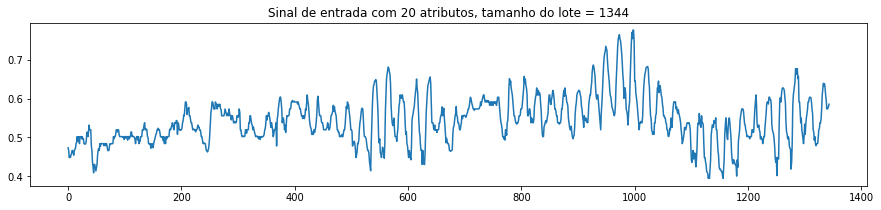

In [212]:
batch = 0   # Primeiro bloco 
signal = 0  # Primeiro sinal a partir dos dados com 20 atributos
seq = x_batch[batch, :, signal]
plt.figure(figsize=(15,3))
plt.title(label='Sinal de entrada com 20 atributos, tamanho do lote = 1344')
plt.plot(seq)
plt.show()

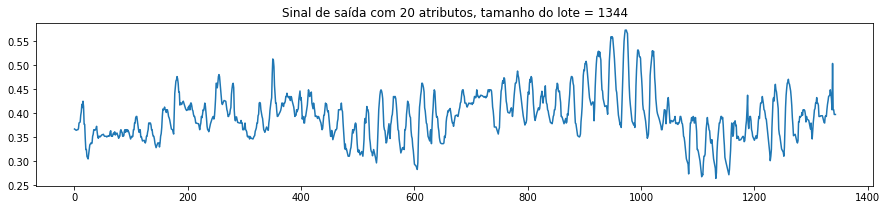

In [215]:
seq = y_batch[batch, :, signal]
plt.figure(figsize=(15,3))
plt.title(label='Sinal de saída com 20 atributos, tamanho do lote = 1344')
plt.plot(seq)
plt.show()